Kaggle "Ames House Price: Advanced Reagression Techniques" competion to predict the house prices 

Using the 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, the challenge is to predict the final price of each home. 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

    by Adarsh Namala
    adarsh.namala@gmail.com

In [1]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import ggplot as gg
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
from sklearn.feature_selection import SelectKBest,f_regression,VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge,LassoCV,RidgeCV
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

Define the verious functions needed

In [3]:
def generate_trans_data(temp_train_data,temp_test_data,int_cols,dummy_cols):
    """
    Function to transforms the categorical data into dummy columns
    """
    temp_train_df = temp_train_data.copy()
    temp_test_df = temp_test_data.copy()
    # set the Id as index
    temp_train_df = temp_train_df.set_index('Id',drop=False)
    temp_test_df = temp_test_df.set_index('Id',drop=False)
    
    # delete SalePrice and Id from the data. We need to keep the index the same
    temp_data = pd.concat([temp_train_df,temp_test_df]).loc[:,temp_train_df.columns]
    
    # drop ID and Sales Price
    drop_cols = ['SalePrice','Id']
    temp_data = temp_data.drop(drop_cols,axis=1)
    
    # if SalesPrice in int_cols, remove SalePrice
    temp_int_cols = list(set(int_cols) - set(['SalePrice']))
    missing_cols = list(set(temp_data.columns) - set(temp_int_cols + dummy_cols))
    if len(missing_cols)> 0:
        print "Columns not used:%s" %(missing_cols)
    
    select_dtype_dummy_cols = dummy_cols
    if len(dummy_cols) > 0:
        # for get_dummies, if its a single variable, it needs to be a string.
        if len(dummy_cols) == 1:
            dummy_cols = dummy_cols[0]

        # get the dummies. split the dummy columns into int_flt and string. for the float columns, we need to 
        # handle the null values so that the values are in int so that we don't get dummies like GarageCars_2.0 which would cause 
        # a mismatch in the column names of train_df and test_df
        
        # for select_dtypes if its a single dummy_cols value it need to be a list
        dummy_int_flt_cols = temp_data[select_dtype_dummy_cols].select_dtypes(include=[np.int64,np.float64]).columns.tolist()
        temp_data.loc[:,dummy_int_flt_cols] = temp_data[dummy_int_flt_cols].fillna(-1).astype(int).astype(str).replace('-1',np.nan)

        temp_df = pd.concat([temp_data[temp_int_cols].fillna(0),
                pd.get_dummies(temp_data[dummy_cols])],axis=1)
   
    else:
        temp_df = temp_data[temp_int_cols].fillna(0)
    
    train_trans_df = temp_df.loc[temp_train_df.index,:]
    test_trans_df = temp_df.loc[temp_test_df.index,:]
    # add the SalePrice to train_trans_df
    train_trans_df.loc[:,'SalePrice'] = temp_train_df['SalePrice']
    return train_trans_df, test_trans_df

In [4]:
def plot_pairplots(data_df,xvars_lst,y_var,plots_perrow=3):
    "Function to plot pairplots for the various xvars gainst a fied y variable"
    var_len = len(xvars_lst)
    req_ncols = plots_perrow
    req_rows = np.int(np.ceil(var_len/float(req_ncols)))
    start_idx = 0    
    for xi in range(0,req_rows):
        end_idx = start_idx + req_ncols
        temp_xvars = xvars_lst[start_idx:end_idx]
        sns.pairplot(data_df,x_vars=temp_xvars,y_vars=y_var,aspect=1.5,size=3)
        start_idx = start_idx + req_ncols

In [5]:
def plot_cat_graphs(data_df, xcols_lst,y_col,plots_per_row=4,plot_type='pointplot',plot_count=False,alt_count=None):
    """
    Function to plots pointplots/boxplot/stripplot for various xcols against a fixed y variable
    """
    if plot_count & (alt_count is None):
        print "Thar bar grpah represents the count of xaxis groups in the data.This gives an idea of the frequency of the group."
    if plot_count & (not alt_count is None):
        print "Thar bar grpah represents the mean of %s"%(alt_count)
    ncols = plots_per_row
    for xstart in range(0,int(np.ceil(len(xcols_lst)/float(ncols)))):
        # set the start and end for each iteration
        xstart = xstart * ncols
        end = xstart + ncols
        end = end if end <= len(xcols_lst) else len(xcols_lst)
        # get the list of req cols
        col_lst = xcols_lst[xstart:end]
        # set the number of plots in each row
        temp_ncols = len(col_lst)
        # create the subplots
        f,axes = plt.subplots(1,temp_ncols,figsize=(20,5),sharey=True)
        for i,xcol in enumerate(col_lst):
            temp_ax = axes[i] if temp_ncols > 1 else axes
            if plot_type == 'pointplot':
                sns.pointplot(xcol,y_col,data=data_df,ax= temp_ax)
            elif plot_type =='boxplot':
                sns.boxplot(xcol,y_col,data=data_df,ax= temp_ax)
            elif plot_type =='stripplot':
                sns.stripplot(xcol,y_col,data=data_df,ax= temp_ax)
            plt.setp(temp_ax.get_xticklabels(),rotation='vertical',size=13)
            
            if plot_count:
                # If xcol is a string then we need to convert it to numeric for count_nonzero to work ints. 
                # we start the dict from 1 since the function is count_nonzero
                xdict= dict(zip(data_df[xcol].unique().tolist(),range(1,len(data_df[xcol].unique())+1)))
                temp_ax_bar = temp_ax.twinx()
                if alt_count is None:
                    x =sns.barplot(data_df[xcol],data_df[xcol].replace(xdict),estimator=np.count_nonzero,ax=temp_ax_bar,ci=None,
                                              facecolor='none',linewidth=0.7)
                else:
                    x = sns.barplot(data_df[xcol],data_df[alt_count],estimator=np.mean,ax=temp_ax_bar,ci=None,
                                  facecolor='none',linewidth=0.7)
                temp_ax_bar.set_yticks([])
                temp_ax_bar.set_ylabel('')

In [6]:
def split_data_run_rf(train_df,train_trans_df,dep_col,split_size,rf_clf,drop_cols_lst='',top_feat=10,getscore=True):
    
    """
    Function to split  the data for training and validation, train the data on the given RandomForest algorithm and predict
    on the test set
    params:
        1) train_df: The original data. Merge the prediction and error. This is for analysis.
        2) train_trans_df: The transformed data used for training and validating the model.
    """
    
    #drop the required columns
    if len(drop_cols_lst) >0:
        temp_train_df = train_trans_df.drop(drop_cols_lst,axis=1)
    else:
        temp_train_df = train_trans_df.copy()        
    # split the data for training and testing
    temp_train_out_df = train_df.copy()
    X_train,X_test,y_train,y_test = train_test_split(temp_train_df.drop(dep_col,axis=1),temp_train_df[dep_col],
                                                     test_size=split_size,random_state=1985)
    rf_clf = rf_clf.fit(X_train,y_train)
    
    # if the splitsize is greater then 0 then use X_test else use X_train
    test_x,test_y =( X_test,y_test) if len(y_test)>0 else (X_train,y_train)
    
    pred_val = rf_clf.predict(test_x)    
    
    if getscore:
        print "The rmsle of prediction is:%0.4f"  %(mean_squared_error((test_y),(pred_val))**0.5)
    
    feat_df = pd.DataFrame(zip(X_train.columns,rf_clf.feature_importances_),columns=['col','val']).sort_values('val',
                                                                                                ascending=False)
    
    print "Top 10 Feat Importance variables:\n%s" %(feat_df.head(top_feat))
    
    # combined the predicted value to the test_x
    # get the index of test_x
    req_idx = test_x.index
    temp_train_out_df = temp_train_out_df.loc[req_idx,:]
    temp_train_out_df['predicted'] = pred_val
    temp_train_out_df['residual'] = temp_train_out_df[dep_col] - temp_train_out_df['predicted']
    
    return temp_train_out_df,rf_clf

def get_combos(data_df,cat_col,dep_col,pval_cutoff=0.05,req_ax=None):
    """
    Function which caluclates the ANOVA of groups in a variable.
    This will help in binning/combining simlar groups before modeling
    """
    
    # get cat_col unique values, 
    idx = data_df.groupby(cat_col)[dep_col].mean().sort_values(ascending=True).index.tolist()
#     xplt = data_df.groupby(cat_col)[dep_col].mean().sort_values().plot(kind='bar')
    # get the values of each group 
    idx_vals = data_df.groupby(cat_col).apply(lambda x:x[dep_col].values)
    
    # for each idx values...get the anova
    start = 0
    end = 1
    combo = list()
    prefix = cat_col
    grp_no = 1
    
    while end <= len(idx):
        # we add 1 since numpy indexing is not right inclusive
        temp_idx = idx[start:end+1]
        # get the varience pvalue of the groups
        pval = stats.f_oneway(*(np.array(idx_vals[temp_idx]))).pvalue
        # check if the p value is significant or not
        if pval < pval_cutoff: # Reject null hypothesis. We need to exclude the last last idx from the grp
            # since the alternate hypo holds, we exclude the last index to the group
            temp_combo = temp_idx[:-1]
            # create a dict
            temp_combo = zip(temp_combo,[prefix+'_'+str(grp_no)]*len(temp_combo))
            combo = combo + [temp_combo]
            # start checking for the next group starting with the last idx
            start = end
            end = start+1
            grp_no = grp_no +  1
        else:
            temp_combo = temp_idx
            end = end+1
            
            if end == len(idx):
                # reached end of the list, since there is no significant varaince between groups, we add them to the combo
                temp_combo = zip(temp_combo,[prefix+'_'+str(grp_no)]*len(temp_combo))
                combo = combo + [temp_combo]
    
    # flatten the values
    combo = [subitem for item in combo for subitem in item]
    
    # check if the laxt index is in the list. If not, add it to the list
    temp_idx = [a for a,b in combo]
    if len(temp_idx) < len(idx):
        # add the last idx
#         grp_no = grp_no+1
        combo = combo + [(idx[-1],prefix+'_'+str(grp_no))]
    
    temp_idx = [a for a,b in combo]
    if len(temp_idx) < len(idx):
        print list(set(idx) - set(temp_idx))
        print temp_idx
        raise ValueError("Check function")
    
    temp_mean = data_df.groupby(cat_col)[dep_col].mean().sort_values().reset_index()
    # map the dict
    temp_mean['temp_grp'] = temp_mean[cat_col].map(dict(combo))
    # convert cat col to string so that sns does not sort the xlabels
#     temp_mean.loc[:,cat_col] = temp_mean[cat_col].astype(str)
    x = sns.barplot(cat_col,dep_col,hue='temp_grp',data=temp_mean,ax=req_ax,order=temp_mean[cat_col].unique())
#     req_ax.legend_.remove()
    plt.setp(req_ax.get_xticklabels(),rotation='vertical')
    x = plt.xticks(rotation='vertical')    
    
    return combo

def get_combos_wraper(data_df,cat_col_lst,dep_col,pval_cutoff=0.05):
    """
    wrapper function fot the get_combos function. This will call the get_combos function for each variable in the cat_col_lst
    """
    
    # determine the shape of the subplots
    var_len = len(cat_col_lst)
    req_ncols = 3
    req_nrows = int(np.ceil(var_len/float(req_ncols)))
    
    combos_lst = list()
    
    # for each row create a row subplot
    for xrow in range(0,req_nrows):
        start = xrow*req_ncols
        end = start + req_ncols
        temp_cat_cols = cat_col_lst[start:end]
        if len(temp_cat_cols) < req_ncols:
            req_ncols = len(temp_cat_cols)
        
        y,axes = plt.subplots(nrows=1,ncols=req_ncols,figsize=(20,5))
        for xi,xvar in enumerate(temp_cat_cols):
            # is there is aonly a single plot, then we cannot index the axes.Handle accordingly
            if len(temp_cat_cols) >1:
                temp_ax = axes[xi]
            else:
                temp_ax = axes
            temp_combo = get_combos(data_df,xvar,dep_col,pval_cutoff,req_ax=temp_ax)
            combos_lst = combos_lst + [(xvar,temp_combo)]    
        
    return combos_lst

In [7]:
# Function to get the cross validated root measn squared error
def cv_rmsle(mdle,xdf,y,cvsize=5):
    rmse = np.mean(np.sqrt(-cross_val_score(mdle,xdf,y,scoring='neg_mean_squared_error',cv=cvsize,n_jobs=-1)))
    return rmse

In [8]:
#read the data
loc_dir = "C:\\Users\\206445860\\Documents\\Adarsh\\Kaggle\\HousePrices\\"
train_file = loc_dir + 'train.csv'
test_file = loc_dir + 'test.csv'

In [9]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [10]:
# get the dtypes
xvals = train_df.dtypes.reset_index().groupby(0)['index'].unique()
for xi,y in enumerate(xvals):
    print "\n****dtype:%s****" %(xvals.index[xi])
    print xvals[xi]



****dtype:int64****
['Id' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold' 'SalePrice']

****dtype:float64****
['LotFrontage' 'MasVnrArea' 'GarageYrBlt']

****dtype:object****
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC'
 'CentralAir' 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu'
 'GarageType' 'GarageFinis

In [11]:
# seperate the columns based on dtype
int_cols = train_df.select_dtypes(include=[np.int64,np.float64]).columns.tolist()
str_cols = train_df.select_dtypes(include=[np.object]).columns.tolist()

# remove 'Id' from int_cols
int_cols.remove('Id')

In [12]:
print train_df.shape, test_df.shape

(1460, 81) (1459, 80)


In [13]:
# set the id as index
train_df.set_index('Id',drop=False,inplace=True)
test_df.set_index('Id',drop=False,inplace=True)

Based on the variance of the variable w.r.t to dependable variable, we will handle the null values

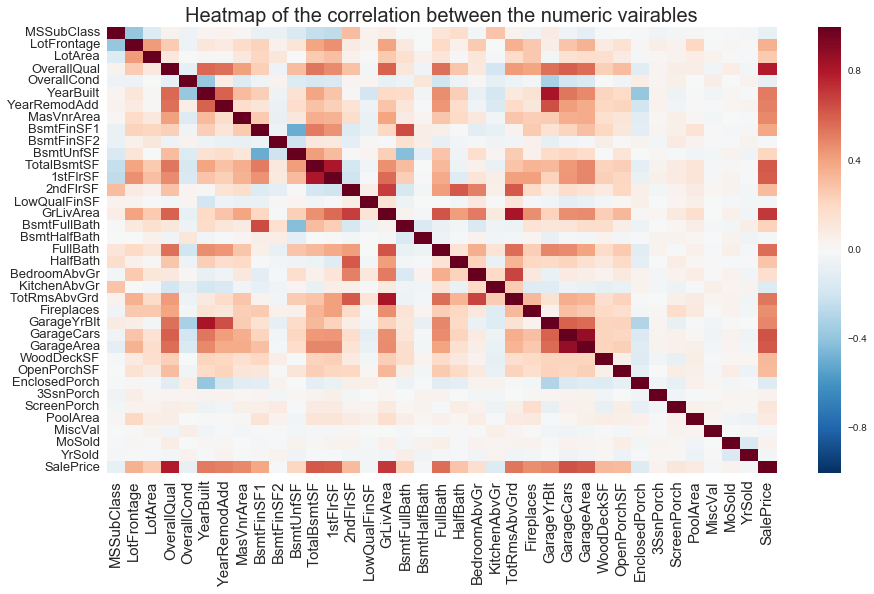

In [14]:
#check the correlation of the int_Cols
plt.figure(figsize=(15,8))

x = sns.heatmap(train_df[int_cols].corr())
plt.title("Heatmap of the correlation between the numeric vairables",size=20)
x= plt.xticks(size=15)
x = plt.yticks(size=13)

    1) (TotalBsmtFS,1stFlrSF),('YearBuilt','GarageYrBlt'), (GrLivArea,TotRmsAbvGrd),  (GarageCars, GarageArea) are highly correlated

    2)From the heat map, we can see that OverallQual, TotalBsmtSF, GrLiveArea, GarageCars, GarageArea have a significant positive impact on SalePrice. 

In [15]:
drop_correlated_cols = [('TotalBsmtFS','1stFlrSF'),('YearBuilt','GarageYrBlt'),
                   ('GrLivArea','TotRmsAbvGrd'),('GarageCars','GarageArea')]
# we keep the 1st element in the tuple and drop the 2nd
drop_correlated_cols = [b for a,b in drop_correlated_cols]

# get the top 10 variables that correlate highly with SalePrice
top_corr_cols = train_df.drop(drop_correlated_cols,axis=1).corr().nlargest(10,'SalePrice').index.tolist()

In [16]:
# split the int_cols into continuous and count/rank variables
int_ordinal_cols = ['MSSubClass','OverallQual','OverallCond','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','MoSold',
                    'GarageCars','Fireplaces','FullBath','BsmtFullBath','BsmtHalfBath','HalfBath']
int_cont_cols = list(set(int_cols) - set(int_ordinal_cols))

Scatter plto of the top correlated variables with SalePrice

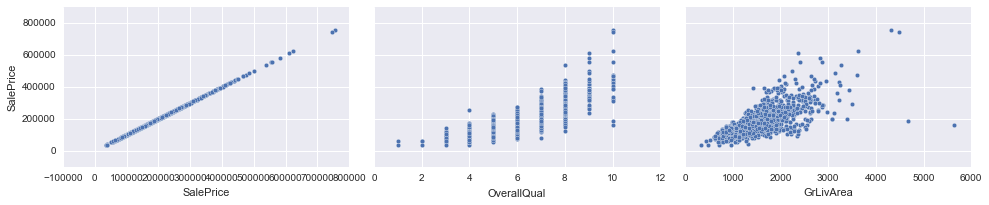

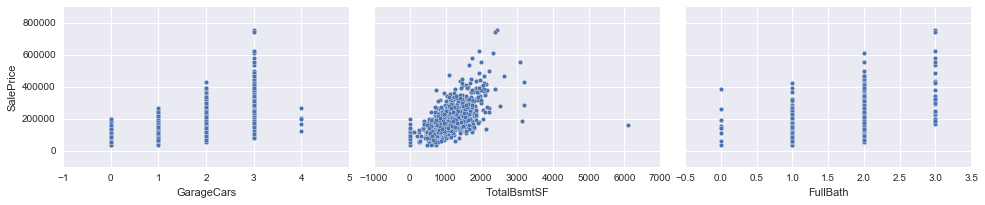

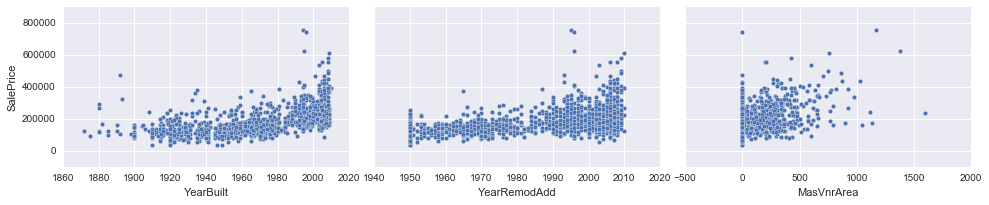

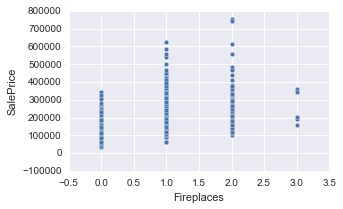

In [17]:
plot_pairplots(train_df,top_corr_cols,'SalePrice')

In [18]:
# print "Boxplot of selected categorical variables against SalePrice"
# plot_cat_graphs(train_df,selected_cat_cols,'SalePrice',plots_per_row=3,plot_type='boxplot',plot_count=True)

In [19]:
# check for null values in the data
train_null = train_df.isnull().sum()
print "Percentage of null values in the training dataset:\n%s" %(((train_null[train_null >0])*100/\
                                                                  len(train_df)).sort_values(ascending=False))

Percentage of null values in the training dataset:
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64


In [20]:
# Get those columns where the null values >= 30%
null_cutoff = 0.3
drop_null_cols = train_null[train_null/len(train_df) > null_cutoff].index.tolist()
print "Columns that have atleast %i percent null values:%s" %(null_cutoff*100,drop_null_cols)

Columns that have atleast 30 percent null values:['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


Handle Null values in 'MasVnrArea'

In [21]:
train_df[['SalePrice','YearBuilt','OverallQual']].describe()

,SalePrice,YearBuilt,OverallQual
count,1460.000000,1460.000000,1460.000000
mean,180921.195890,1971.267808,6.099315
std,79442.502883,30.202904,1.382997
min,34900.000000,1872.000000,1.000000
25%,129975.000000,1954.000000,5.000000
50%,163000.000000,1973.000000,6.000000
75%,214000.000000,2000.000000,7.000000
max,755000.000000,2010.000000,10.000000


In [22]:
# train_df.groupby('Neighborhood').agg({'YearBuilt':'median','SalePrice':'median'}).sort_values('YearBuilt',ascending=False)

Majority of the values are 0.
It can be the case the houses in the neighborhood have imilar type of construction.

In [23]:
train_df.groupby('Neighborhood')['MasVnrArea'].median()

Neighborhood
Blmngtn     18.0
Blueste      0.0
BrDale     291.0
BrkSide      0.0
ClearCr      0.0
CollgCr     24.0
Crawfor      0.0
Edwards      0.0
Gilbert      0.0
IDOTRR       0.0
MeadowV      0.0
Mitchel      0.0
NAmes        0.0
NPkVill      0.0
NWAmes     164.0
NoRidge    391.0
NridgHt    289.0
OldTown      0.0
SWISU        0.0
Sawyer       0.0
SawyerW      0.0
Somerst     36.0
StoneBr      0.0
Timber      82.0
Veenker      0.0
Name: MasVnrArea, dtype: float64

To fill NaNs, we use the median of the Neighborhood 

In [24]:
# Handle missing values of MasVnrArea
train_df.loc[:,'MasVnrArea'] = train_df.groupby('Neighborhood')['MasVnrArea'].transform(lambda x:x.fillna(x.median()))

In [25]:
# print "For each variable, identify similar groups w.r.t variance on SalePrice using F Test"
# req_combos_lst = ['OverallQual','HouseStyle','SaleType','Neighborhood']
# combos = get_combos_wraper(train_df,req_combos_lst,'SalePrice')

### Identifying outliers

Lets look at GrLivArea and TotalBsmtSF w.r.t SalePrice

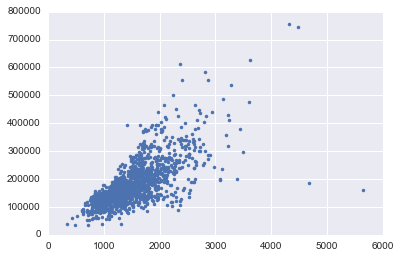

In [26]:
plt.plot(train_df.GrLivArea,train_df.SalePrice,'.')

Remove those outliers where GrLiveArea > 4000

In [27]:
train_df = train_df[train_df.GrLivArea < 4000]

### Feat Engineering:
#### Explore Combined GrLivArea and TotalBsmtSF

Person Correlation:
AbvGrd+Bsmt:0.821
AbvGrdSF:0.721
BsmtSF:0.647


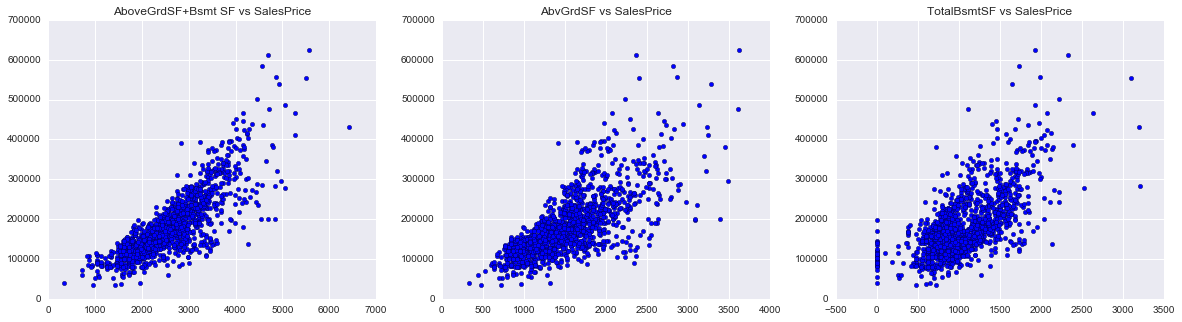

In [28]:
y,axes=plt.subplots(1,3,figsize=(20,5))
axes[0].scatter(train_df.GrLivArea + train_df.TotalBsmtSF,train_df.SalePrice)
axes[1].scatter(train_df.GrLivArea ,train_df.SalePrice)
axes[2].scatter(train_df.TotalBsmtSF,train_df.SalePrice)
axes[0].set_title("AboveGrdSF+Bsmt SF vs SalesPrice")
axes[1].set_title("AbvGrdSF vs SalesPrice")
axes[2].set_title("TotalBsmtSF vs SalesPrice")

x,y,z = (stats.pearsonr(train_df.GrLivArea + train_df.TotalBsmtSF,train_df.SalePrice)[0],
                    stats.pearsonr(train_df.GrLivArea ,train_df.SalePrice)[0],
                    stats.pearsonr(train_df.TotalBsmtSF,train_df.SalePrice)[0])
print "Person Correlation:\nAbvGrd+Bsmt:%0.3f\nAbvGrdSF:%0.3f\nBsmtSF:%0.3f" %(x,y,z)          

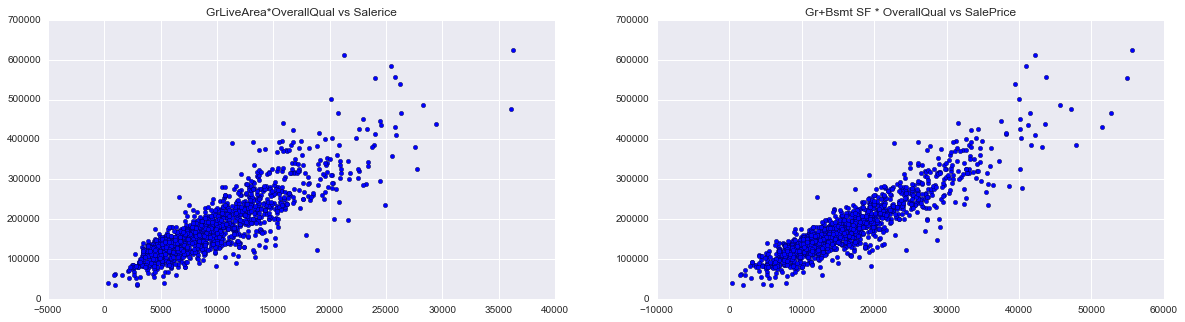

In [29]:
# mulitple OverallQual
y,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(train_df.GrLivArea * train_df.OverallQual, train_df.SalePrice)
ax[1].scatter((train_df.GrLivArea + train_df.TotalBsmtSF) * train_df.OverallQual, train_df.SalePrice)
ax[0].set_title('GrLiveArea*OverallQual vs Salerice')
ax[1].set_title('Gr+Bsmt SF * OverallQual vs SalePrice')

In [30]:
print "Pearson correlation: GrLivSF*Qual and Price:%0.2f" %(stats.pearsonr(train_df.GrLivArea * train_df.OverallQual, 
                                                                             train_df.SalePrice)[0])
print "Pearson correlation: TotalSF*Qual and Price:%0.2f" %(stats.pearsonr((train_df.GrLivArea + train_df.TotalBsmtSF)\
                                                                           * train_df.OverallQual, train_df.SalePrice)[0])

Pearson correlation: GrLivSF*Qual and Price:0.86
Pearson correlation: TotalSF*Qual and Price:0.91


In [31]:
tempx = ((train_df.GrLivArea + train_df.TotalBsmtSF)* train_df.OverallQual)
stats.pearsonr(tempx,np.log(train_df.SalePrice))

(0.88149477453565173, 0.0)

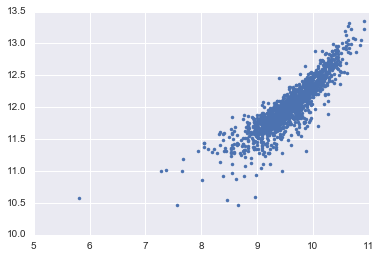

In [32]:
plt.plot(np.log(tempx),np.log(train_df.SalePrice),'.')

#### YearBuilt

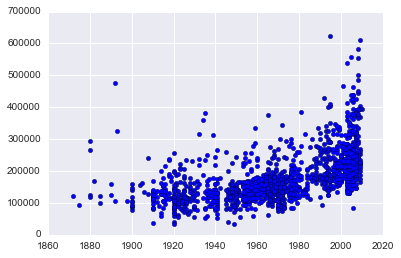

In [33]:
plt.scatter(train_df.YearBuilt,train_df.SalePrice)

Mostly, the SalePrice increases with YearBuilt,however there are outliers too..check the OverallQuality for Olderbuildings

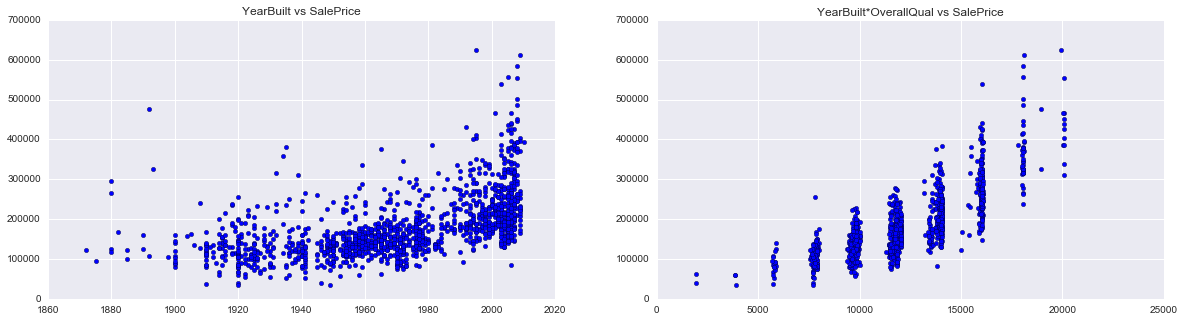

In [34]:
y,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(train_df.YearBuilt,train_df.SalePrice)
ax[1].scatter(train_df.YearBuilt*train_df.OverallQual,train_df.SalePrice)
ax[0].set_title("YearBuilt vs SalePrice")
ax[1].set_title('YearBuilt*OverallQual vs SalePrice')

In [35]:
tempx = train_df.YearBuilt * train_df.OverallQual
x = stats.pearsonr(train_df.YearBuilt,train_df.SalePrice)[0]
y = stats.pearsonr(tempx,train_df.SalePrice)[0]
print "Pearson correlation for:\n YearBuilt & SalePrice:%0.6f\n YearBuilt*Qual \
& SalePrice:%.3f\n YearBuilt*Qual**2 & SalePrice:%.3f" %(x,y,y**2)

Pearson correlation for:
 YearBuilt & SalePrice:0.535279
 YearBuilt*Qual & SalePrice:0.807
 YearBuilt*Qual**2 & SalePrice:0.651


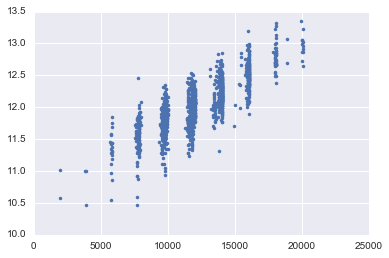

In [36]:
plt.plot((tempx),np.log(train_df.SalePrice),'.')

In [37]:
# tempz = ((train_df.YearBuilt) * train_df.OverallQual)
# plt.figure(figsize=(10,5))
# plt.plot((tempz),train_df.SalePrice/(train_df.GrLivArea),'.')

In [38]:
# temp_cols = ['GrLivArea','TotalBsmtSF','SalePrice','OverallQual','YearBuilt','YrSold']
# train_df[(tempx> 17000) & (train_df.GrLivArea < 4000)][temp_cols].sort_values('SalePrice')

### Explore TotalRooms and BedRooms above grade

Thar bar grpah represents the count of xaxis groups in the data.This gives an idea of the frequency of the group.
Feat1 = TotalRooms above ground - Bedrroms
Feat2 = TotalRooms - Bedrooms - Kitchen


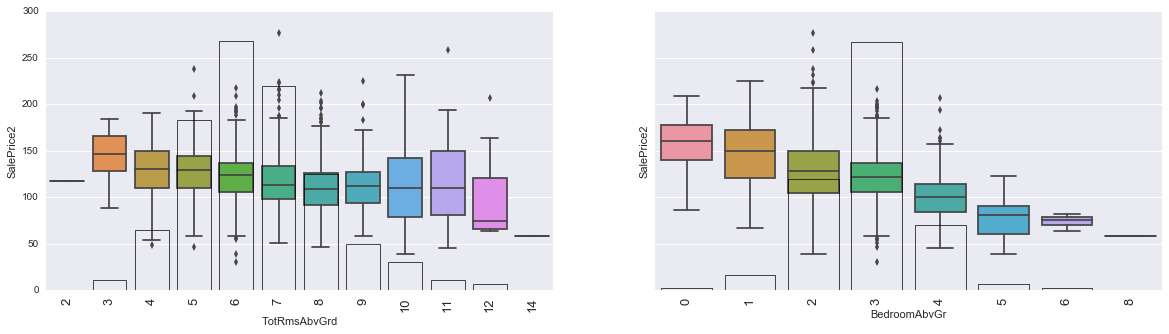

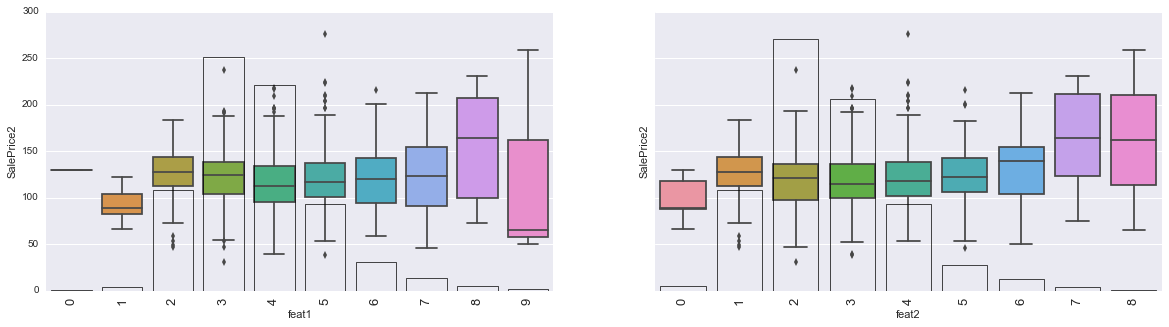

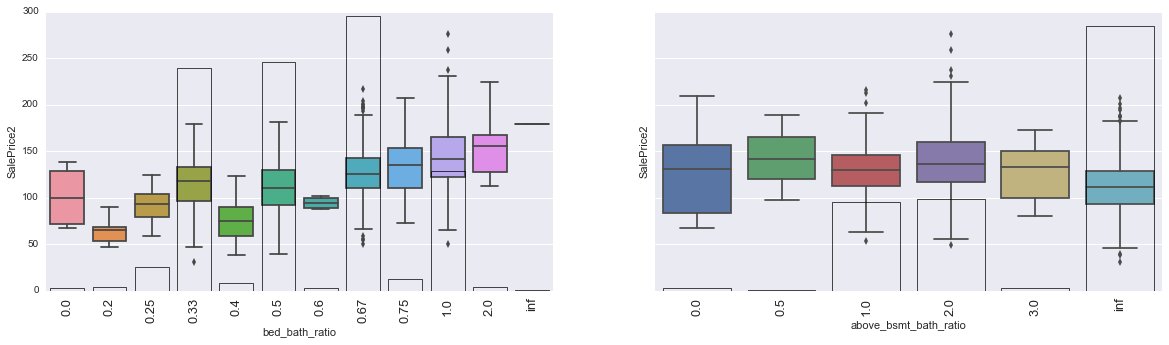

In [39]:
temp_cols = ['TotRmsAbvGrd','BedroomAbvGr','KitchenAbvGr','SalePrice','FullBath','GrLivArea','YearBuilt',
             'OverallQual','BldgType','HouseStyle','BsmtFullBath','TotalBsmtSF']
tempx = train_df[train_df.GrLivArea < 4000][temp_cols]
tempx['SalePrice2'] = tempx.SalePrice/tempx.GrLivArea
tempx['SalePrice3'] = tempx.SalePrice / (tempx.GrLivArea + tempx.TotalBsmtSF)
tempx.loc[:,'feat1'] = tempx.TotRmsAbvGrd - tempx.BedroomAbvGr
tempx.loc[:,'feat2'] = (tempx.TotRmsAbvGrd - tempx.BedroomAbvGr - tempx.KitchenAbvGr)
tempx['bed_bath_ratio'] = (tempx.FullBath/tempx.BedroomAbvGr).round(2)
tempx['above_bsmt_bath_ratio'] = (tempx.FullBath/tempx.BsmtFullBath).round(2)
tempx['room_size'] = tempx.TotRmsAbvGrd/tempx.GrLivArea
plot_cat_graphs(tempx,['TotRmsAbvGrd','BedroomAbvGr','feat1','feat2',
                       'bed_bath_ratio','above_bsmt_bath_ratio'],
                'SalePrice2',2,plot_type='boxplot',plot_count=True)

print "Feat1 = TotalRooms above ground - Bedrroms\nFeat2 = TotalRooms - Bedrooms - Kitchen"

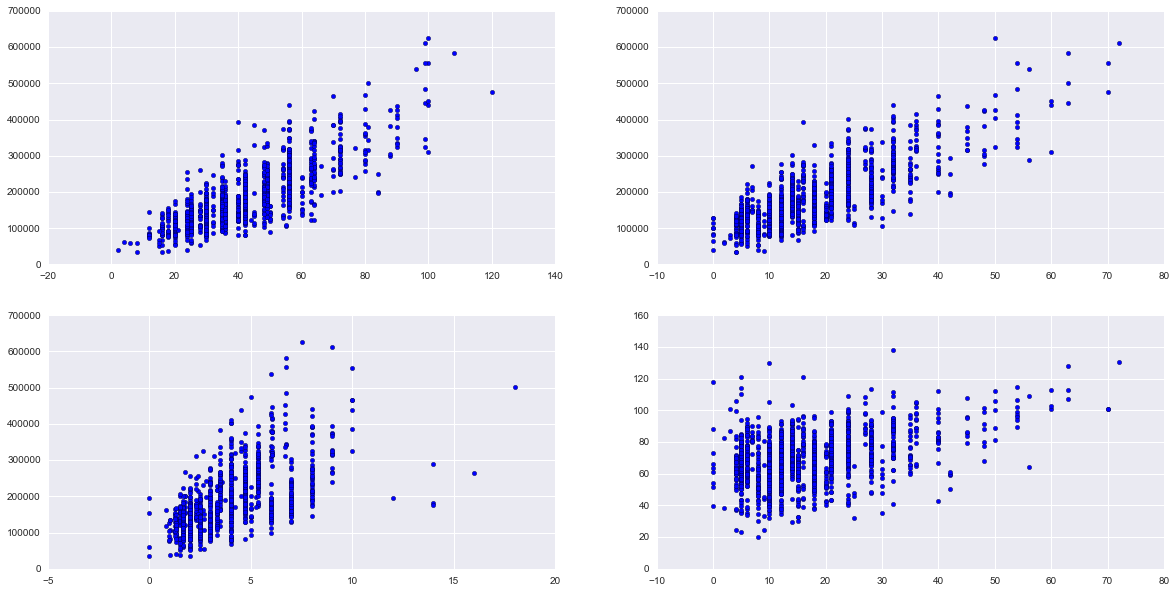

In [40]:
y,ax = plt.subplots(2,2,figsize=(20,10))
ax[0][0].scatter((tempx.TotRmsAbvGrd * tempx.OverallQual),tempx.SalePrice)
ax[0][1].scatter((tempx.feat2* tempx.OverallQual),tempx.SalePrice)
ax[1][0].scatter(tempx.bed_bath_ratio * tempx.OverallQual, tempx.SalePrice)
ax[1][1].scatter(tempx.feat2 * tempx.OverallQual, tempx.SalePrice3)

### Explore kitchecn attributes

In [41]:
train_df.KitchenQual.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

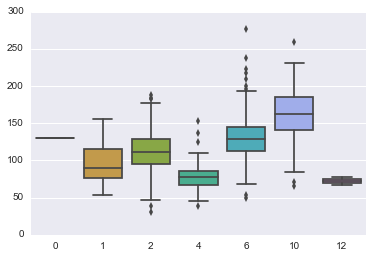

In [42]:
kitchenqual_dict = {'Ex':10,'Gd':6,'TA':2,'Fa':1}
sns.boxplot(train_df.KitchenQual.replace(kitchenqual_dict)*train_df.KitchenAbvGr,train_df.SalePrice/ train_df.GrLivArea)

In [43]:
train_df[train_df.KitchenAbvGr==3][['OverallQual','KitchenQual']]

,OverallQual,KitchenQual
Id,,
49,4,TA
810,5,TA


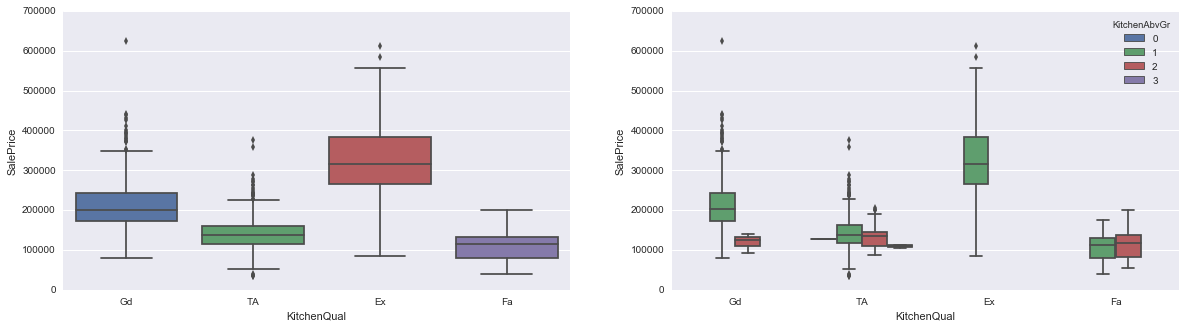

In [44]:
y,axes = plt.subplots(1,2,figsize=(20,5))
x = sns.boxplot('KitchenQual','SalePrice',data=train_df,ax = axes[0])
x = sns.boxplot('KitchenQual','SalePrice',data=train_df,hue='KitchenAbvGr',ax = axes[1])

From the graphs above, we can see that Kitchen quality plays a much signifncant than No.of Kitchens. We need to compare this with GrLivArea

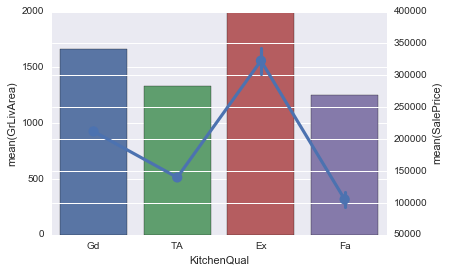

In [45]:
ax1 = sns.barplot('KitchenQual','GrLivArea',data=train_df,estimator=np.mean,ci=None)
ax2 = ax1.twinx()
sns.pointplot('KitchenQual','SalePrice',data=train_df,ax=ax2)

The bargraph is the mean GrLivAreaSF by Kitchen quality and the line graph is the mean SalesPrice by KitchenQual.

### Explore the Heating aspects of each house sold

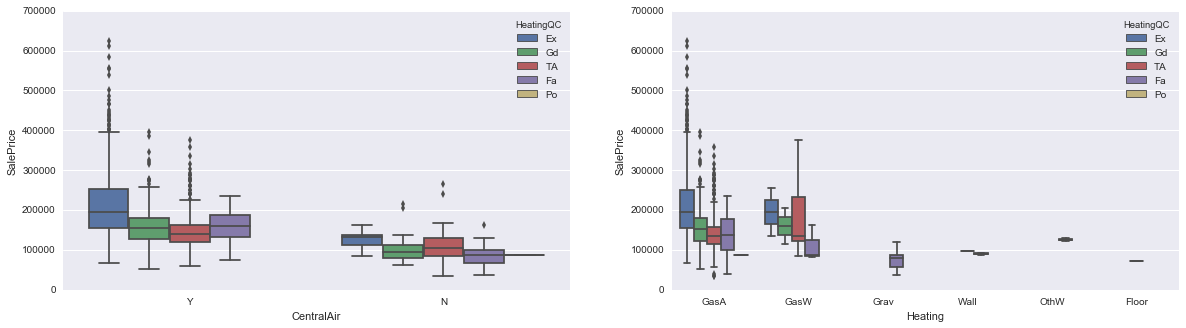

In [46]:
y,axes = plt.subplots(1,2,figsize=(20,5))
x=sns.boxplot('CentralAir','SalePrice',data=train_df,hue='HeatingQC',ax=axes[0])
x=sns.boxplot('Heating','SalePrice',data=train_df,hue='HeatingQC',ax=axes[1])

There is a different distribution of SalePrice depending on HeatingQC and CentralAir

In [47]:
heat_qual_dict = {'Ex':11,'Gd':7,'TA':7,'Fa':3,'Po':3}
central_air_dict = {'Y':20,'N':1}
tempx = zip(train_df.CentralAir.replace(central_air_dict) * train_df.HeatingQC.replace(heat_qual_dict),train_df.SalePrice)
tempx= pd.DataFrame(tempx,columns=['heating','SalePrice'])

In [48]:
# get the mean of the GrLivAreas for each tempx
tempx['mean_GrLivArea'] = train_df.groupby(tempx.heating)['GrLivArea'].transform('mean')

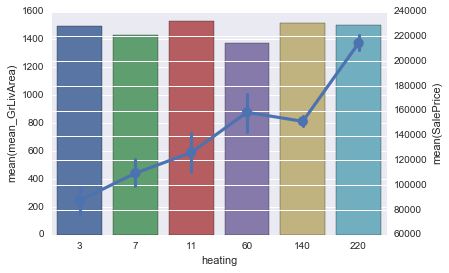

In [49]:
ax1= sns.barplot('heating','mean_GrLivArea',data=tempx)
ax2 = ax1.twinx()
ax1 = sns.pointplot('heating','SalePrice',data=tempx,ax=ax2)

The bargraphs is the mean GrLivArea SF for each heating combination. The line graph is the mean SalePrice of each heating type(combination of CentralAir and Heating Qual). Clearly the type of heating impacts the SalePrice

### Explore the Impact of Garage attributes on the SalePrice

GarageAttributes - GarageType,GarageYrBlt, GarageFinish, GarageCars, Garage Area, GarageQual, GarageCond

In [50]:
cols_garage = ['GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond','GarageArea','GarageYrBlt']
train_df[['GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond']].apply(lambda x:x.unique().tolist())

GarageType      [Attchd, Detchd, BuiltIn, CarPort, nan, Basmen...
GarageFinish                                 [RFn, Unf, Fin, nan]
GarageCars                                        [2, 3, 1, 0, 4]
GarageQual                              [TA, Fa, Gd, nan, Ex, Po]
GarageCond                              [TA, Fa, nan, Gd, Po, Ex]
dtype: object

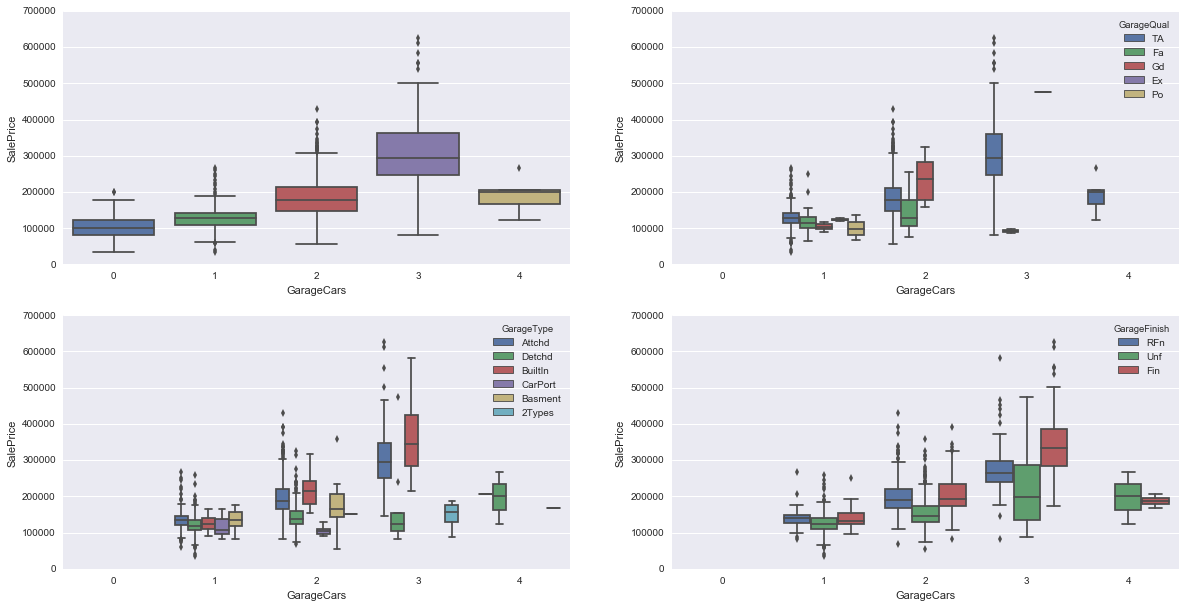

In [51]:
y,axes = plt.subplots(2,2,figsize=(20,10))
sns.boxplot('GarageCars','SalePrice',data=train_df,ax=axes[0][0])
sns.boxplot('GarageCars','SalePrice',data=train_df,hue='GarageQual',ax=axes[0][1])
sns.boxplot('GarageCars','SalePrice',data=train_df,ax=axes[1][0],hue='GarageType')
sns.boxplot('GarageCars','SalePrice',data=train_df,hue='GarageFinish',ax=axes[1][1])

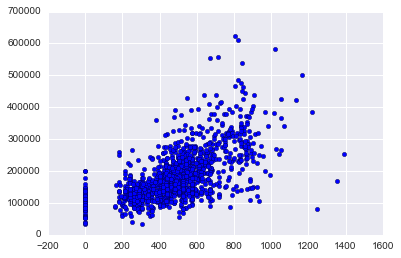

In [52]:
plt.scatter(train_df.GarageArea,train_df.SalePrice)

From the above plot, we can see that there is a linear relation between GarageArea and SalePrice, we can clean it up by adding more meta data to GarageArea

In [53]:
gr_finish_dict = {'RFn':2,'Fin':2,'Unf':1}
gr_type_dict = {'Attchd':2,'BuiltIn':2,'Detchd':1,'CarPort':1,'Basment':1,'2Types':1,np.nan:0}
gr_qual_dict = {'Ex': 3, 'Fa': 1, 'Gd': 3, 'Po': 1, 'TA': 2}

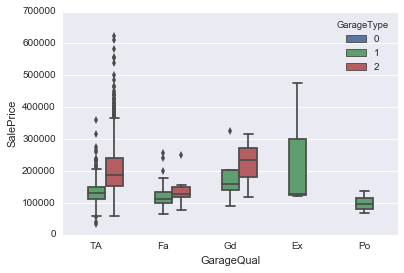

In [54]:
sns.boxplot(train_df.GarageQual,train_df.SalePrice,hue=train_df.GarageType.replace(gr_type_dict))

### Explore the impact of Basement
Basements related variables: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnSF,TotalBsmtSF

Thar bar grpah represents the count of xaxis groups in the data.This gives an idea of the frequency of the group.


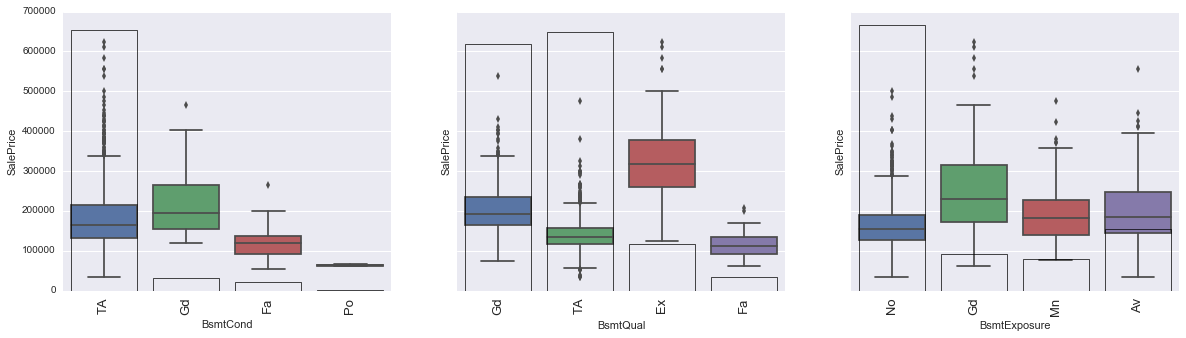

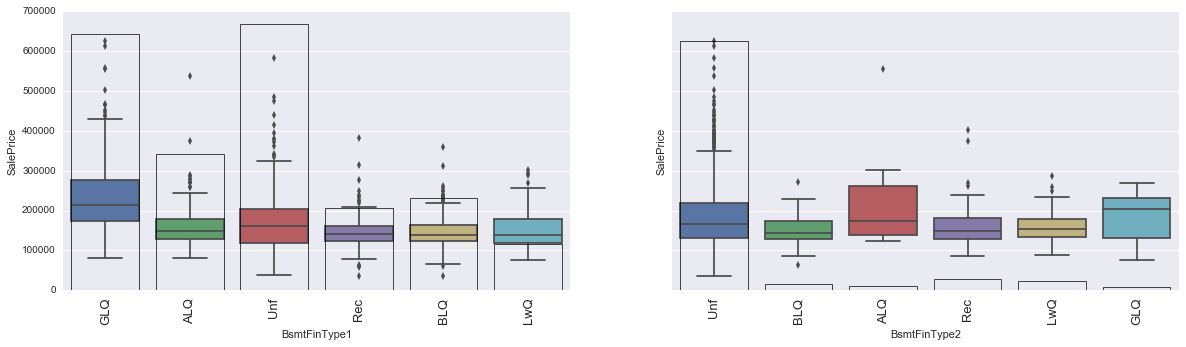

In [55]:
plot_cat_graphs(train_df,['BsmtCond','BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2'],'SalePrice',
                plots_per_row=3, plot_type='boxplot',plot_count=True)

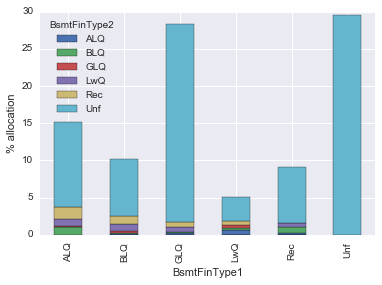

In [56]:
(train_df.groupby(['BsmtFinType1','BsmtFinType2']).size()*100/float(len(train_df))).unstack().plot(kind='bar',stacked=True)
x= plt.ylabel('% allocation')

From the above graph we can see that FinType2 is mostly Unf (unfinished)

In [57]:
# train_df.groupby('BsmtFinType1')['SalePrice'].median().sort_values()

In [58]:
bsmt_qual_dict ={'Ex':23,'Gd':7,'TA':1,'Fa':1,np.nan:0}
bsmt_exp = {'Gd':3,'No':1,'Mn':1,'Av':1,'No':1,np.nan:0}
bsmt_fintype1 = {'GLQ':1,'ALQ':1,'Unf':1,'Rec':1,'BLQ':1,'LwQ':1,np.nan:0}

In [59]:
tempx = train_df.BsmtQual.replace(bsmt_qual_dict) * train_df.BsmtExposure.replace(bsmt_exp) * \
                                            train_df.BsmtFinType1.replace(bsmt_fintype1)
tempx = pd.DataFrame(zip(tempx,train_df.SalePrice,train_df.TotalBsmtSF,
                         train_df.GrLivArea),columns=['bsmt','SalePrice','TotalBsmtSF','GrLivArea'])

In [60]:
tempx['mean_GrLivArea'] = tempx.groupby('bsmt')['GrLivArea'].transform('mean')

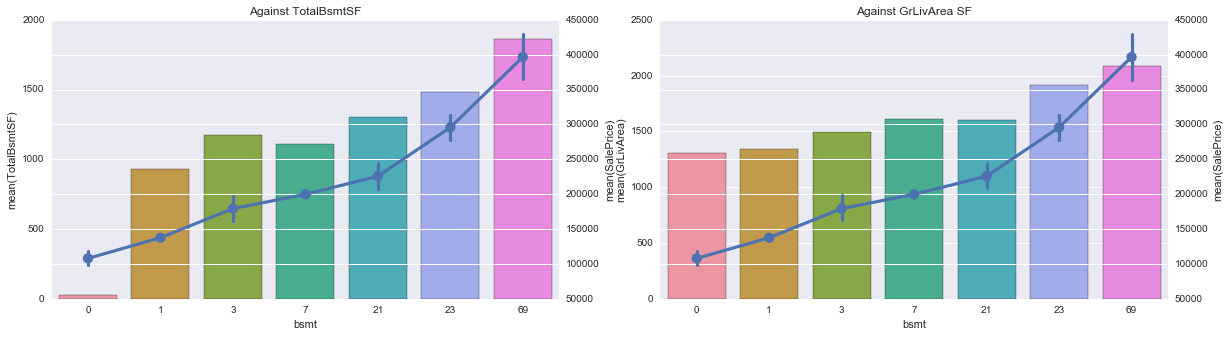

In [61]:
y,axes = plt.subplots(1,2,figsize=(20,5))
sns.barplot('bsmt','TotalBsmtSF',data=tempx,estimator=np.mean,ci=None,ax=axes[0])
ax02 = axes[0].twinx()
sns.pointplot('bsmt','SalePrice',data=tempx,ax=ax02)

sns.barplot('bsmt','GrLivArea',data=tempx,estimator=np.mean,ci=None,ax=axes[1])
ax12 = axes[1].twinx()
sns.pointplot('bsmt','SalePrice',data=tempx,ax=ax12)
axes[0].set_title('Against TotalBsmtSF')
axes[1].set_title('Against GrLivArea SF')

From the abpve graphs we can see that there is interaction terms with certain bsmt features. Also, we can see that the GrLivArea has a greater weightage than bsmt

### Explore the impact of Fireplaces

In [62]:
train_df.GarageCars.value_counts(dropna=False)

2    823
1    369
3    178
0     81
4      5
Name: GarageCars, dtype: int64

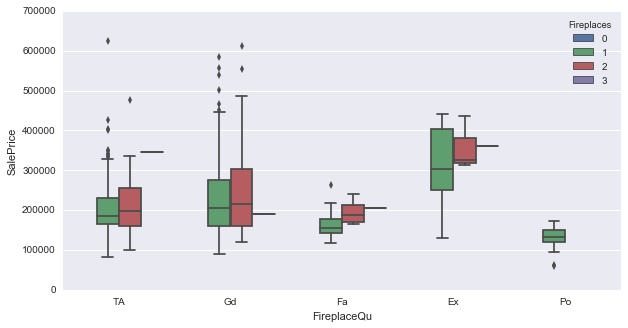

In [63]:
plt.figure(figsize=(10,5))
sns.boxplot('FireplaceQu','SalePrice',data=train_df,hue='Fireplaces')

In [64]:
fire_qual_dict= {'Ex':17,'Gd':4,'TA':4,'Fa':1,'Po':1,np.nan:0}
tempx = train_df.Fireplaces * train_df.FireplaceQu.replace(fire_qual_dict)
tempx = pd.DataFrame(zip(tempx,train_df.SalePrice,train_df.GrLivArea),columns=['fire','SalePrice','GrLivArea'])

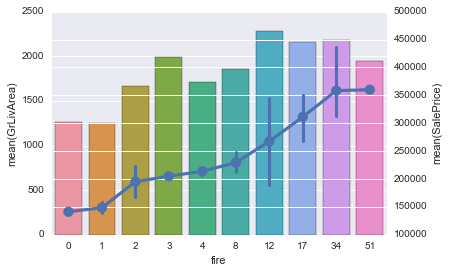

In [65]:
ax1 = sns.barplot('fire','GrLivArea',data=tempx,estimator=np.mean,ci=None)
ax2 = ax1.twinx()
x =sns.pointplot('fire','SalePrice',data=tempx,ax=ax2)

### Explore SaleType and SaleCondition

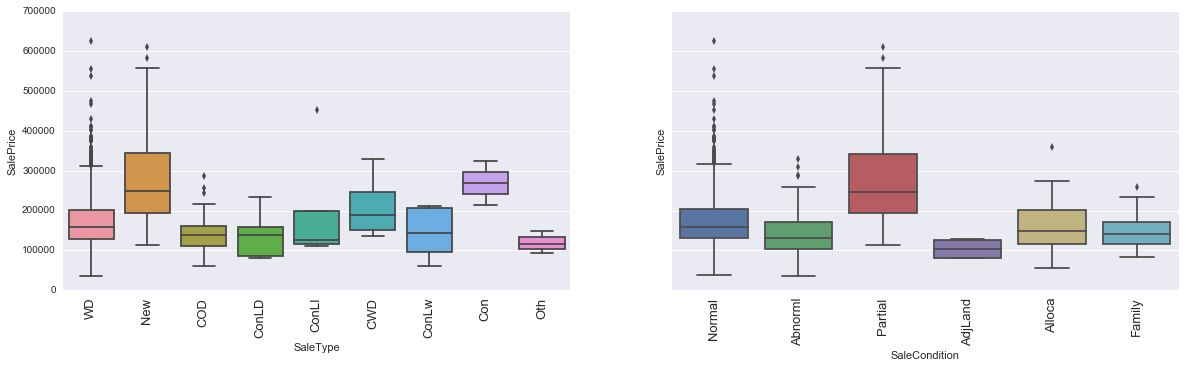

In [66]:
plot_cat_graphs(train_df,['SaleType','SaleCondition'],'SalePrice',plots_per_row=3,plot_type='boxplot')

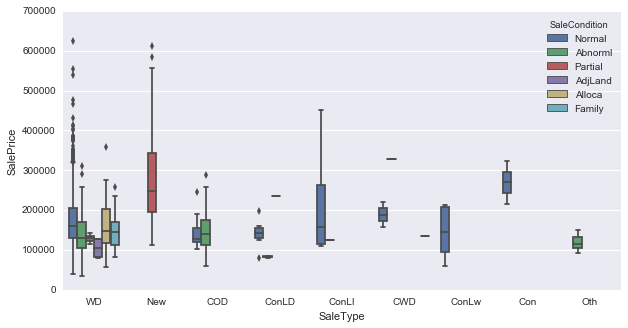

In [67]:
plt.figure(figsize=(10,5))
sns.boxplot('SaleType','SalePrice',data=train_df,hue='SaleCondition')

From the above graph, we only need a boolean if the SaleTye is New or not

### Explore Exterior Conditions

'RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','MasVnrArea', 'ExterQual', 'ExterCond','Foundation'

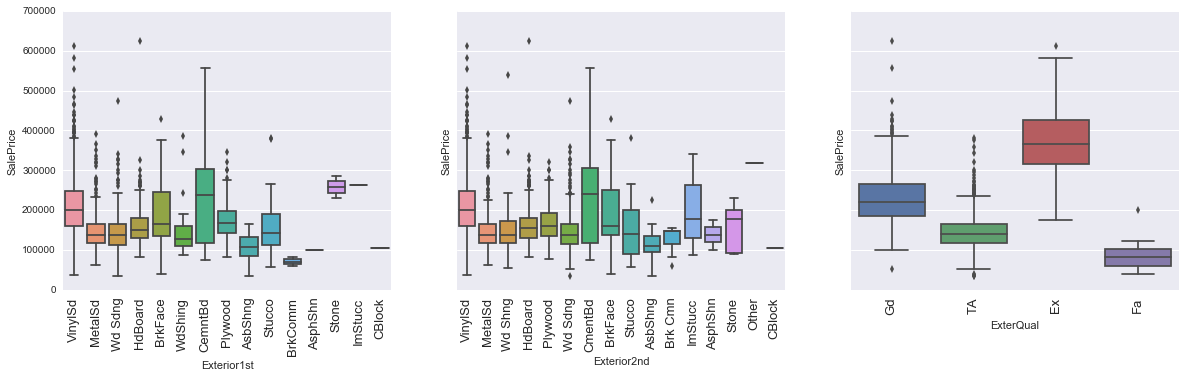

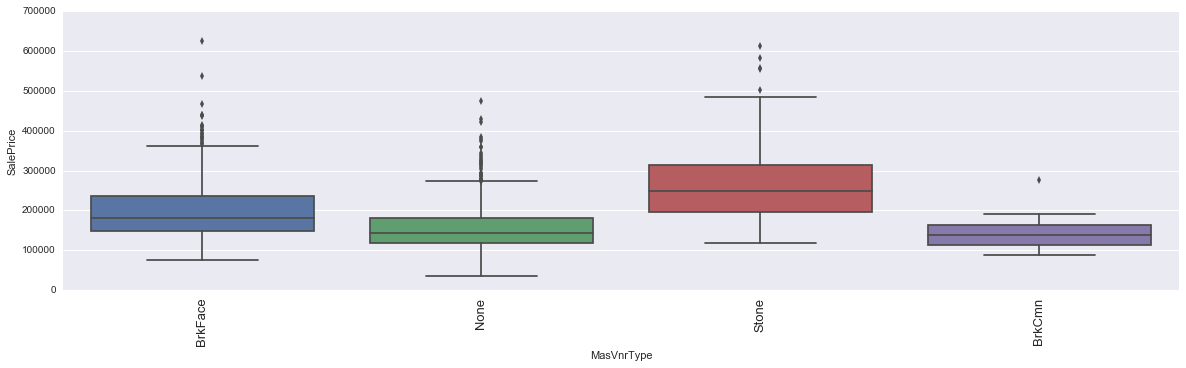

In [68]:
plot_cat_graphs(train_df,['Exterior1st','Exterior2nd','ExterQual','MasVnrType'],'SalePrice',plots_per_row=3,plot_type='boxplot')

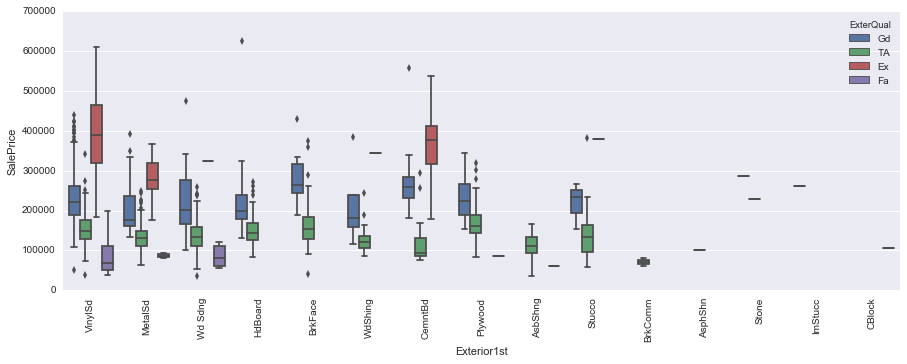

In [69]:
plt.figure(figsize=(15,5))
x = sns.boxplot('Exterior1st','SalePrice',data=train_df,hue='ExterQual')
x = plt.xticks(rotation='vertical')

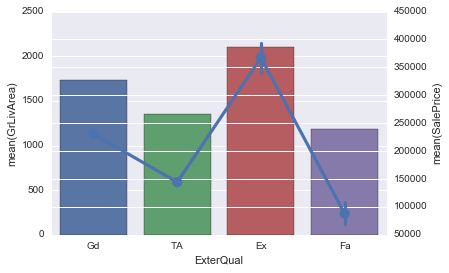

In [70]:
ax1 = sns.barplot('ExterQual','GrLivArea',data=train_df,estimator=np.mean,ci=None)
ax2 = ax1.twinx()
sns.pointplot('ExterQual','SalePrice',data=train_df,ax=ax2)

#### Using Anova identify categories within a colum which are similar

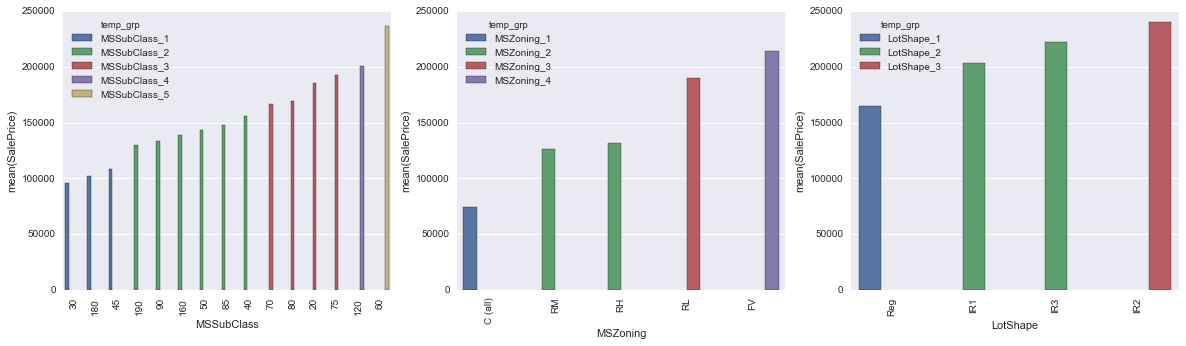

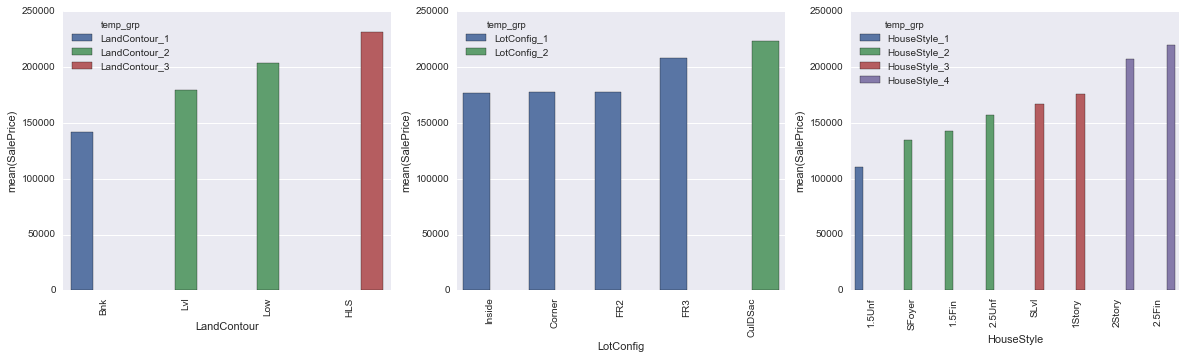

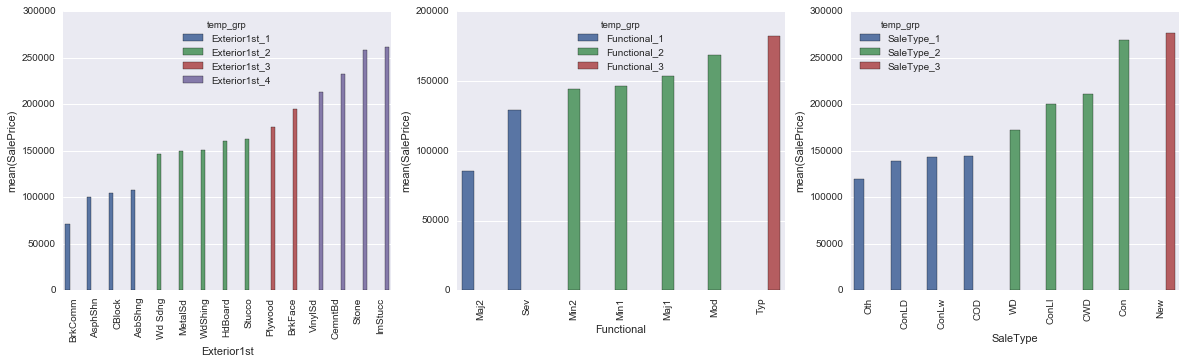

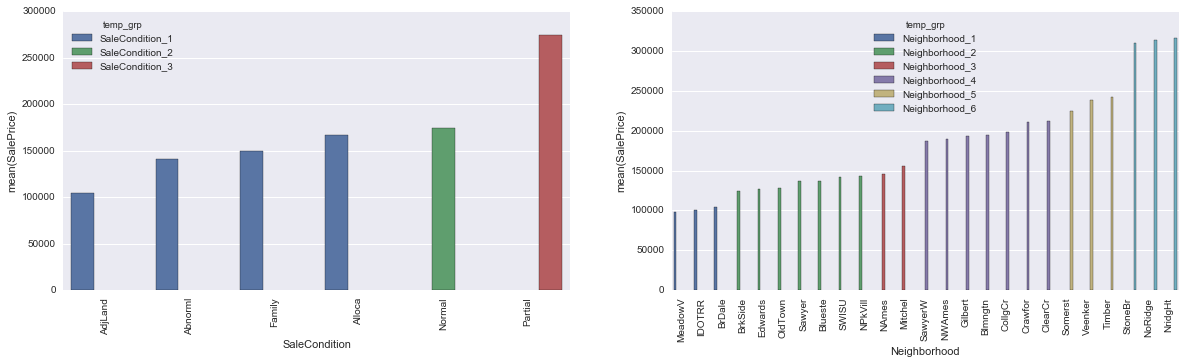

In [331]:
temp_cols = ['MSSubClass','MSZoning','LotShape','LandContour','LotConfig','HouseStyle','Exterior1st','Functional','SaleType',
             'SaleCondition','Neighborhood']
anova_var_dict = get_combos_wraper(train_df,temp_cols,'SalePrice')

#### Build the required features

In [730]:
combined_df = pd.concat([train_df,test_df],ignore_index=True).loc[:,train_df.columns]

In [731]:
# set Id as index
combined_df = combined_df.set_index('Id',drop=False)

In [732]:
#drop SalePRice
combined_df = combined_df.drop('SalePrice',axis=1)

In [733]:
# Within a column, replace those categories which are similar

In [734]:
for xcol, temp_map in anova_var_dict:
    print "Replaceing for column:%s" %xcol
    # convert the string to int
    temp_map = [(y,int(x.split('_')[1])) for (y,x) in temp_map]
    # convet the map to dict
    temp_map = dict(temp_map)
    # check if the combined_df column does not contain a certain key
    miss_key = list(set(combined_df[xcol].dropna().unique().tolist()) - set(dict(temp_map).keys()))
    # add the keys to the dict. Set the value to nan
    temp_map.update(dict(zip(miss_key,[np.nan]*len(miss_key))))

    # update the combined_df with the dict
    combined_df.loc[:,xcol] = combined_df[xcol].replace(temp_map)

Replaceing for column:MSSubClass
Replaceing for column:MSZoning
Replaceing for column:LotShape
Replaceing for column:LandContour
Replaceing for column:LotConfig
Replaceing for column:HouseStyle
Replaceing for column:Exterior1st
Replaceing for column:Functional
Replaceing for column:SaleType
Replaceing for column:SaleCondition
Replaceing for column:Neighborhood


#### Handle null values for numerical variables

In [735]:
xcols= combined_df.select_dtypes(include=[np.int64,np.float64]).columns.tolist()
tempx = combined_df[xcols].isnull().sum()*100/len(combined_df)
xcols = tempx[tempx>0].index.tolist()
tempx[tempx > 0].sort_values(ascending=False)

LotFrontage     16.672384
GarageYrBlt      5.454545
MasVnrArea       0.514580
MSZoning         0.137221
Functional       0.068611
BsmtHalfBath     0.068611
BsmtFullBath     0.068611
SaleType         0.034305
GarageArea       0.034305
GarageCars       0.034305
TotalBsmtSF      0.034305
BsmtUnfSF        0.034305
BsmtFinSF2       0.034305
BsmtFinSF1       0.034305
Exterior1st      0.034305
MSSubClass       0.034305
dtype: float64

In [736]:
combined_df.loc[:,xcols] = combined_df[xcols].apply(lambda x:x.fillna(x.median()))

In [737]:
# built feature for Garage
gr_fin_dict= {np.nan: 0, 'Fin': 1, 'RFn': 1, 'Unf': 0}
gr_qual_dict = {'Ex': 3, 'Fa': 1, 'Gd': 3, 'Po': 1, 'TA': 2,np.nan:0}
gr_type_dict = {np.nan: 0,  '2Types': 1, 'Attchd': 2, 'Basment': 1, 'BuiltIn': 2, 'CarPort': 1, 'Detchd': 1}
xcolos_dict = [('GarageFinish',gr_fin_dict),('GarageType',gr_type_dict),('GarageQual',gr_qual_dict)]
for col,xdict in xcolos_dict:
#     print combined_df[col].unique()
    combined_df.loc[:,col] = combined_df[col].replace(xdict)
#     print combined_df[col].unique()

combined_df.loc[:,'feat_garage'] = combined_df.GarageArea * combined_df.GarageType * \
                                    combined_df.GarageQual * combined_df.GarageFinish


In [738]:
# dict for Kitchen
kitchenqual_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':1,np.nan:0}
combined_df.loc[:,'KitchenQual'] = combined_df.KitchenQual.replace(kitchenqual_dict)
combined_df.KitchenQual.unique()

array([4, 3, 5, 1, 0], dtype=int64)

In [739]:
# dict for Central air
heat_qual_dict = {'Ex':11,'Gd':7,'TA':7,'Fa':3,'Po':3}
central_air_dict = {'Y':20,'N':1}
# For heating we create a feat which is a product of central air and heatquality
combined_df['feat_heat'] = combined_df.HeatingQC.replace(heat_qual_dict) * combined_df.CentralAir.replace(central_air_dict)
combined_df.feat_heat.unique()

combined_df.loc[:,'HeatingQC'] = combined_df.HeatingQC.replace(heat_qual_dict)
combined_df.loc[:,'CentralAir'] = combined_df.CentralAir.replace(central_air_dict)

In [740]:
# dict for Bsmt
bsmt_qual_dict ={'Ex':23,'Gd':7,'TA':1,'Fa':1,np.nan:0}
bsmt_exp = {'Gd':3,'No':1,'Mn':1,'Av':1,'No':1,np.nan:0}
# We create a feat_bsmt column as a multiple of the above two
combined_df['feat_bsmt'] = combined_df.BsmtQual.replace(bsmt_qual_dict) * combined_df.BsmtExposure.replace(bsmt_exp)
print combined_df['feat_bsmt'].unique()

combined_df.loc[:,'BsmtQual'] = combined_df.BsmtQual.replace(bsmt_qual_dict)
combined_df.loc[:,'BsmtExposure'] = combined_df.BsmtExposure.replace(bsmt_exp)

[ 7 21  1 23  0  3 69]


In [741]:
# dicts for Fireplace
fire_qual_dict = {np.nan: 0, 'Ex': 17, 'Fa': 1, 'Gd': 4, 'Po': 1, 'TA': 4}
# we create a feat_fire column . product of quality and fireplaces
combined_df['feat_fire'] = combined_df.FireplaceQu.replace(fire_qual_dict) * combined_df.Fireplaces
print combined_df.feat_fire.unique()

combined_df.loc[:,'FireplaceQu'] = combined_df.FireplaceQu.replace(fire_qual_dict)

[ 0  4  8  1 17 12  2 51 34  3 16]


In [742]:
# Create Total SF feature.
combined_df['feat_totalSF'] = ((combined_df.GrLivArea + combined_df.TotalBsmtSF.fillna(0))* combined_df.OverallQual)**0.5

In [743]:
# set GrLivArea to log
combined_df.loc[:,'GrLivArea'] = np.log(combined_df.GrLivArea)

In [744]:
# # Set LandContour as bin depending on whether its Bnk
# combined_df.loc[:,'LandContour'] = (combined_df.LandContour != 'Bnk').astype(int)

# combined_df.LandContour.unique()
# combined_df.LandContour.value_counts(dropna=False)

# set feat for SaleType...check 
# combined_df.loc[:,'SaleType'] = (combined_df.SaleType == 'New').astype(int)

# unfishied feat
# combined_df.loc[:,'feat_unfinished'] = combined_df.HouseStyle.str.contains('Unf').astype(int)

# combined_df.loc[:,'feat_floors'] = combined_df.HouseStyle.str.replace('[^0-9.]','').replace('',1.75).astype(float)

# combined_df.loc[:,'feat_salecondition'] = combined_df.SaleCondition.isin(['Normal','Partial']).astype(int)

In [745]:
# bed bath ratio
combined_df.loc[:,'feat_bed_bath_ratio'] = ((combined_df.FullBath/combined_df.BedroomAbvGr).replace(np.inf,0) >= 1).astype(int)

In [746]:
# feat_YearBuilt_Qual
combined_df.loc[:,'feat_YrBuiltQual'] = (combined_df.YearBuilt * combined_df.OverallQual)**2
# feat YrRemodeld Qual
# combined_df.loc[:,'feat_YrRemdQual'] = (combined_df.YearRemodAdd * combined_df.OverallQual)**2

In [747]:
# Rooms Features
combined_df.loc[:,'feat_rooms'] = combined_df.TotRmsAbvGrd - combined_df.BedroomAbvGr - combined_df.KitchenAbvGr

In [748]:
# contains basement featur
combined_df.loc[:,'feat_contains_bsmt'] = (combined_df.TotalBsmtSF > 0).astype(int)
# feat Lot_aread
combined_df.loc[:,'feat_lotarea'] = np.log(combined_df.LotArea)

In [749]:
# # fillnull values of MasVnrArea and LotFrontage
# # for MasVnrArea, we get the mean by neighborhood
# combined_df.loc[:,'MasVnrArea'] = combined_df.groupby(['Neighborhood']).transform(lambda x:x.fillna(x.median()))
# temp_bool = combined_df.LotFrontage.isnull()
# combined_df.loc[temp_bool,'LotFrontage'] = combined_df.loc[temp_bool,'LotArea']**0.5

# combined_df[['SaleCondition','feat_salecondition']].drop_duplicates()

# tempxcols = combined_df.select_dtypes(include= [np.float64,np.int64]).columns.tolist()

# np.log1p(combined_df.MasVnrArea).hist(bins=40)

# combined_df[tempxcols].apply(lambda x:stats.skew(x.dropna()))

# feature year sold - year remodeled
# combined_df.loc[:,'feat_YrRemod'] = (combined_df.YrSold - combined_df.YearRemodAdd)**2

# # dict for MSSubClass
# xdict = get_combos_wraper(train_df,['MSSubClass'],'SalePrice')
# mssubclass_dict = dict(xdict)['MSSubClass']
# mssubclass_dict = dict([(a,int(b.split('_')[1])) for a,b in mssubclass_dict])
# combined_df.loc[:,'MSSubClass'] = combined_df.MSSubClass.replace(mssubclass_dict)

# xdict = get_combos_wraper(train_df,['YearBuilt'],'SalePrice')

# yrbuild_dict = dict(xdict)['YearBuilt']
# yrbuild_dict = dict([(a,int(b.split('_')[1])) for a,b in yrbuild_dict])
# combined_df.loc[:,'YearBuilt'] = combined_df.YearBuilt.replace(yrbuild_dict)

In [754]:
# create a list of all the feat cols
feat_int_cols = ['feat_bsmt','feat_fire','feat_heat','feat_totalSF','feat_bed_bath_ratio','feat_YrBuiltQual','feat_rooms',
                'feat_contains_bsmt','feat_YrRemdQual','feat_lotarea','feat_salecondition','feat_unfinished','feat_floors',
                'feat_garage']

feat_int_cols = list(set(feat_int_cols) & set(combined_df.columns))

In [756]:
# int_cols = combined_df.select_dtypes(include=[np.int64,np.float64]).columns

# skew_cols = combined_df[int_cols].apply(lambda x:stats.skew(x))

# skew_cols = skew_cols[skew_cols > 0.75].index
# combined_df.loc[:,skew_cols] = np.log1p(combined_df[skew_cols])

In [757]:
xtrain_df = combined_df[combined_df.Id.isin(train_df.Id.unique().tolist())]
xtest_df = combined_df[combined_df.Id.isin(test_df.Id.unique().tolist())]

In [758]:
# get the dummies
combined_df = pd.get_dummies(combined_df)

In [759]:
# combined_df[feat_int_cols]

In [760]:
xtrain_trans_df = combined_df[combined_df.Id.isin(train_df.Id.unique().tolist())]
xtest_trans_df = combined_df[combined_df.Id.isin(test_df.Id.unique().tolist())]

In [761]:
# # temp_req_cols = ['feat_totalSF','feat_heat','feat_bsmt','feat_fire','GarageCars','KitchenQual','YearBuilt',
# #                  'SalePrice','SaleType','BedroomAbvGr','FullBath','HalfBath']
# # temp_shift_cols = ['MSSubClass','FullBath']
# temp_int_ordinal_cols = int_ordinal_cols[:]
# temp_req_ordinal_cols = []
# temp_int_ordinal_cols = list(set(temp_int_ordinal_cols) - set(temp_req_ordinal_cols))
# temp_str_to_ordinal_cols = ['GarageFinish','GarageType', 'LandContour', 'KitchenQual'] + ['HeatingQC','CentralAir',
#                                                                     'BsmtQual','BsmtExposure','FireplaceQu']

# temp_int_cols = int_cont_cols + feat_int_cols + temp_int_ordinal_cols + temp_str_to_ordinal_cols
# temp_str_cols = list(set(str_cols) - set(temp_str_to_ordinal_cols))
# temp_cat_cols =  temp_str_cols  + temp_req_ordinal_cols
# xtrain_trans_df,xtest_trans_df = generate_trans_data(xtrain_df,xtest_df,temp_int_cols,temp_cat_cols)
# # set the salePrice to log

In [762]:
# drop required columns
xtrain_trans_df = xtrain_trans_df.drop('Id',axis=1)
xtest_trans_df = xtest_trans_df.drop('Id',axis=1)
# set rhe salePrice to Log
ytrain = np.log(train_df.SalePrice)

In [763]:
Xtrain = xtrain_trans_df.copy()

In [764]:
def get_cv_score(mdl_lst,xtrain_temp,ytain_temp,nsplit=5,getfeatures=True):
    """
    Function to run cross validation on mulitple models and get individual and combined cross validation score
    """
    mdl = mdl_lst
    cv = KFold(n_splits=nsplit,random_state=1985)
    cv = cv.split(xtrain_temp)
    cv_scores = []
    # get score for each cv
    for i,idx in enumerate(cv):
        print "runnning cv:%i" %(i)
        idx_train,idx_test = idx
        temp_xtrain,temp_xtest = xtrain_temp.iloc[idx_train,:], xtrain_temp.iloc[idx_test,:]
        temp_ytrain,temp_ytest = ytain_temp.iloc[idx_train],ytain_temp.iloc[idx_test]

        # fit the models
        mdl = [xmdl.fit(temp_xtrain,temp_ytrain) for xmdl in mdl]
        # get the prediction
        pred = [xmdl.predict(temp_xtest) for xmdl in mdl]
        # add combined_pred
        pred = pred + [[np.mean(x) for x in zip(*pred)]]
        score = [mean_squared_error(temp_ytest,xpred)**0.5 for xpred in pred]
        # add the score the main score list
        cv_scores = cv_scores + [score]

    # get the names of the models 
    mdl_names = [xmdl.__class__.__name__ for xmdl in mdl] + ['Combined']
    # get the cv score
    combined_cv_scores = [np.round(np.mean(x),4) for x in zip(*cv_scores)]
    print "The cv score:"
    for xval in  zip(mdl_names,combined_cv_scores):
        print "  %s:%0.4f" %(xval[0],xval[1])
    return None

In [765]:
# Determine the best aplha for Ridge regression
alphas = [0.0001,0.001,0.01,0.1,1,5,10,15,20,25,30,40,50,100]

In [766]:
Xtrain.dtypes.value_counts()

float64    145
int64       43
int32        2
dtype: int64

In [767]:
rf_mdl = RandomForestRegressor(n_estimators=300,min_samples_leaf=2,n_jobs=-1,random_state=1985,)
lasso_mdl = LassoCV(alphas=alphas,random_state=1985,cv=5)
gb_mdl = GradientBoostingRegressor(random_state=1985,min_samples_leaf=3,
                                     learning_rate=0.1,subsample=1,n_estimators=400,loss='huber',max_features='sqrt')
ridge_mdl = RidgeCV(alphas=alphas,scoring='neg_mean_squared_error',cv=5)

mdl = [rf_mdl,lasso_mdl,gb_mdl,ridge_mdl]
get_cv_score(mdl,Xtrain,ytrain)

runnning cv:0
runnning cv:1
runnning cv:2
runnning cv:3
runnning cv:4
The cv score:
  RandomForestRegressor:0.1329
  LassoCV:0.1127
  GradientBoostingRegressor:0.1133
  RidgeCV:0.1136
  Combined:0.1102


In [729]:
rf_mdl = RandomForestRegressor(n_estimators=300,min_samples_leaf=2,n_jobs=-1,random_state=1985,)
lasso_mdl = LassoCV(alphas=alphas,random_state=1985,cv=5)
gb_mdl = GradientBoostingRegressor(random_state=1985,min_samples_leaf=3,
                                     learning_rate=0.1,subsample=1,n_estimators=400,loss='huber',max_features='sqrt')
ridge_mdl = RidgeCV(alphas=alphas,scoring='neg_mean_squared_error',cv=5)

mdl = [rf_mdl,lasso_mdl,gb_mdl,ridge_mdl]
get_cv_score(mdl,Xtrain,ytrain)

runnning cv:0
runnning cv:1
runnning cv:2
runnning cv:3
runnning cv:4
The cv score:
  RandomForestRegressor:0.1346
  LassoCV:0.1133
  GradientBoostingRegressor:0.1156
  RidgeCV:0.1140
  Combined:0.1114


In [594]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=7, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0.01, reg_lambda=1,
       scale_pos_weight=1, seed=1985, silent=True, subsample=1)

Between Ridge and Lasso, Lasso performs better and between GB and RF, GB does better

In [768]:
lasso_mdl = LassoCV(alphas=alphas,random_state=1985,cv=5)
gb_mdl = GradientBoostingRegressor(random_state=1985,min_samples_leaf=3,max_features='sqrt',
                                     learning_rate=0.1,subsample=1,n_estimators=400,loss='huber')

mdl = [lasso_mdl,gb_mdl]
get_cv_score(mdl,Xtrain,ytrain)

runnning cv:0
runnning cv:1
runnning cv:2
runnning cv:3
runnning cv:4
The cv score:
  LassoCV:0.1127
  GradientBoostingRegressor:0.1133
  Combined:0.1078


In [769]:
def model_stack(mdl_lst,xtrain,ytrain,temp_test_df,cv,get_score = True,blend=False):
    
    """
    Function which predicts using cross validation for various modles in the modl_lst. The prediction is stored as a feature, 
    which will later be used for stacking
    """
    cv = cv.split(xtrain)
    
    # create a trainmeta dataset with the prediction of the model
    xtrain_meta = xtrain.copy()
    test_meta = temp_test_df.copy()
    # create the columns needed to store the predictions
    pred_cols = ['mdl_' +str(i) for i in range(0,len(mdl_lst))]
    for xcol in pred_cols:
        xtrain_meta[xcol] = np.nan
        
    for i,idx in enumerate(cv):
        print "running for cv:%i" %(i)
        # get the train and test index
        idx_train, idx_test = idx
        temp_xtrain,temp_xtest = xtrain.iloc[idx_train,:], xtrain.iloc[idx_test,:]
        temp_ytrain, temp_ytest = ytrain.iloc[idx_train], ytrain.iloc[idx_test]
        
        # train the mdls on train set
        mdl_lst = [mdl.fit(temp_xtrain,temp_ytrain) for mdl in mdl_lst]
        # add the predict value of testset to meta data
        mdl_predict = [mdl.predict(temp_xtest) for mdl in mdl_lst]
        # add the predict values to the meta dataset
        for i,pred in enumerate(mdl_predict):
            col_name = pred_cols[i]
            # get the index from idx_train
            xtrain_meta.loc[temp_xtest.index.tolist(),col_name] = pred
    
    # if blend. Get the average of the model predictions
    if blend:
        col_name='mdl_blend'
        xtrain_meta[col_name] = xtrain_meta[pred_cols].mean(axis=1)
    
    # train the model on the complete train dataset and make prediction on the testset
    for i,mdl in enumerate(mdl_lst):
        # train the model
        mdl = mdl.fit(xtrain,ytrain)
        test_meta[pred_cols[i]] = mdl.predict(temp_test_df)
    
    # if blend, get the mean of the predictions
    if blend:
        test_meta['mdl_blend'] = test_meta[pred_cols].mean(axis=1)
    
    if get_score:
        for i,mdl in enumerate(mdl_lst):
            mdl_name = mdl.__class__.__name__
            xpredcol = pred_cols[i]
            score = mean_squared_error(ytrain,xtrain_meta[xpredcol])**0.5
            print "The score for %s,column %s is : %0.5f" %(mdl_name,xpredcol,score)
    
    # get the score of blend
    if blend:
        score = mean_squared_error(ytrain,xtrain_meta['mdl_blend'])**0.5
        print "The score for %s,column %s is : %0.5f" %('mean of various predictions','mdl_blend',score)           
        
    return xtrain_meta, test_meta,mdl_lst

In [770]:
del lasso_mdl
del gb_mdl

In [771]:
temp_cv = KFold(n_splits=5,random_state=1985)

temp_dropcols = ['GrLivArea','GarageArea','LotArea','YearBuilt']
lasso_mdl = LassoCV(alphas=alphas,random_state=1985,cv=5,)
gb_mdl = GradientBoostingRegressor(random_state=1985,min_samples_leaf=3,max_features='sqrt',
                                     learning_rate=0.1,subsample=1,n_estimators=400,loss='huber')

mdl = [lasso_mdl,gb_mdl]
train_meta,test_meta,xmdl_lst = model_stack(mdl,Xtrain,ytrain,xtest_trans_df,temp_cv)

running for cv:0
running for cv:1
running for cv:2
running for cv:3
running for cv:4
The score for LassoCV,column mdl_0 is : 0.11276
The score for GradientBoostingRegressor,column mdl_1 is : 0.11347


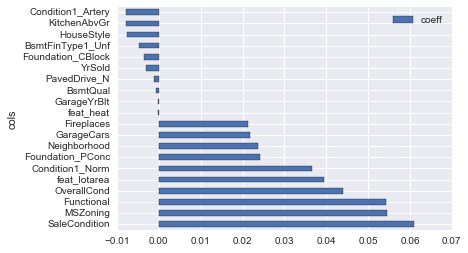

In [772]:
lass_feat_df = pd.DataFrame(zip(Xtrain.columns,lasso_mdl.coef_),columns=['cols','coeff']).sort_values('coeff',ascending=False)
temp_df = pd.concat([lass_feat_df.head(10),lass_feat_df.tail(10)])
temp_df.plot(x='cols',y='coeff',kind='barh')

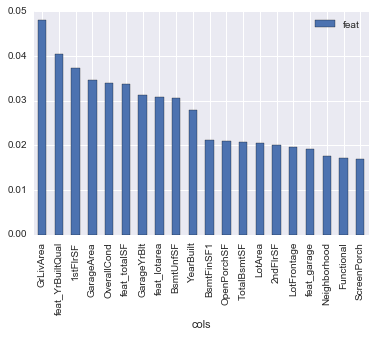

In [773]:
gb_feat_df = pd.DataFrame(zip(Xtrain.columns,gb_mdl.feature_importances_),columns=['cols','feat']).sort_values('feat',ascending=False)
gb_feat_df.head(20).plot(x='cols',y='feat',kind='bar')

In [1023]:
gb_stack_mdl = GradientBoostingRegressor(n_estimators=1000,learning_rate=0.05,min_samples_leaf=6,max_depth=2,max_features='sqrt',
                                        random_state=1985,loss='huber')
gb_stack_params = {'max_depth':[2,3,4,5]}
gb_stack_grid = GridSearchCV(gb_stack_mdl,gb_stack_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
gb_stack_grid = gb_stack_grid.fit(train_meta[stack_cols],ytrain)

In [1014]:
# gb_stack_mdl = GradientBoostingRegressor(n_estimators=400,learning_rate=0.05,min_samples_leaf=2,max_depth=2,max_features='sqrt',
#                                         random_state=1985,loss='huber')
gb_stack_mdl = gb_stack_grid.best_estimator_
temp_cv = KFold(n_splits=5,random_state=1985)
stack_cols = kbest_cols
gb_stack_mdl = gb_stack_mdl.fit(train_meta[stack_cols],ytrain)
gb_stack_predict = gb_stack_mdl.predict(test_meta[stack_cols])

In [1019]:
test_predict = np.exp(gb_stack_predict) #np.exp(0.3*gb_stack_predict + 0.7*lasso_stack_predict)
test_predict = pd.DataFrame(zip(test_df.Id,test_predict),columns=['Id','SalePrice'])

In [1020]:
test_predict.loc[:,'SalePrice'] = test_predict.SalePrice.round(0).astype(int)
test_predict.to_csv(loc_dir+'/output/test27.csv',index=False)

# Misc

In [ ]:
# plt.hist(pred2), plt.hist(pred1)

In [ ]:
sns.jointplot(train_df.LotArea,train_df.GrLivArea)

In [ ]:
temp_df.GarageFinish.unique(), temp_df.GarageType.unique()

In [ ]:
sns.boxplot(temp_df.GarageFinish * temp_df.GarageType, temp_df.SalePrice,hue=temp_df.GarageCars)

In [ ]:
x = get_combos_wraper(temp_df,['OverallCond'],'SalePrice')

In [ ]:
xdict = dict([(a,int(b.split('_')[1])) for (a,b) in dict(x)['OverallCond']])

In [ ]:
xdict = {1: 11, 2: 11, 3: 11, 4: 11, 5: 17, 6: 13, 7: 13, 8: 13, 9: 17}

In [ ]:
tempx = temp_df.OverallCond.replace(xdict)

In [ ]:
tempx.value_counts()

In [ ]:
plt.figure(figsize=(20,10))
sns.pointplot(temp_df.OverallQual,temp_df.SalePrice,hue=tempx)

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot('OverallQual','SalePrice',data=temp_df[temp_df.OverallQual >7],hue='OverallCond')

In [ ]:
temp_df[temp_df.OverallQual == 9].groupby('OverallCond').agg({'GrLivArea':'mean','SalePrice':'mean',
                                                              'feat_totalSF':'mean','KitchenQual':'mean'})

In [ ]:
temp_bool = temp_df.OverallQual ==9
sns.boxplot('KitchenQual','SalePrice',data=temp_df[temp_bool])

In [ ]:
temp_df[temp_df.OverallQual == 9]

In [ ]:
temp_df.MSZoning.value_counts(dropna)

In [ ]:
temp_bool = temp_df.orig_residual.abs()>40000
temp_df[temp_bool]['OverallQual'].value_counts()

In [ ]:
temp_bool = 

In [ ]:
temp_df[temp_df.orig_residual.abs()>40000][int_ordinal_cols + ['orig_residual']].sort_values('orig_residual')

In [ ]:
y,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(temp_df.SalePrice,temp_df.orig_residual)
ax[1].scatter(temp_df.feat_totalSF,temp_df.SalePrice)
ax[0].set_title("SlaePrice vs Residula")
ax[1].set_title("TotalSF vs SalePrice")